# Steps
1. Get mini-gridworld running
2. Create policy class with variable number of actions
3. Create a replay buffer

Loop steps 4-8:

4. Run a random policy to gather random samples, where actions are primitives + learned options
5. Create a eigenvector and learn by minimizing G
6. Determine the instantiation and termination sets
7. Instantiate a new policy with primitive actions
8. Learn with the eigenvector reward function (f(s) - f(s'))


9. Instantiate a new policy with primitives and all learned options
10. Run experiments

# Ideas
- For long-term learning, you may have to explore more and more to learn a good eigenvector for all the states you can cover. It might make sense to start from the eigenvector from the previous iteration instead of from scratch. You might be able to even make some changes to it to reflect the new option without sampling from the environment.
- The reward generated by the eigenvector is nice because it is smooth, but if there is a quicker way to reach a terminal state that was not explored enough during the exploration phase, it likely won't be chosen because the amount of timesteps taken to reach a state is not explicitly taken into account. It is implicitly taken into account during the random walk, but because we cannot explore forever, we will not find all paths. A discount factor of 1 would weigh all trajectories that get to the terminal state equally, which would be better than a discount factor of less than 1. Maybe it would be helpful to incentivise the agent to find quicker paths by subtracting a constant from the reward at each timestep. In practice though, this may not be a big enough issue to worry about.
- Could reuse trajectories from exploration with IRL or behavior cloning to learn options faster
- Eigenvector tend to have values in a very small range, it would make sense to normalize then so that you don't have to worry about the ideal lr changing.

In [1]:
import copy

import torch
from torch import nn
from torch import optim
from torch.distributions import Categorical
from gym_minigrid.wrappers import *
import matplotlib.pyplot as plt
import numpy as np

from utils import *
from ppo import *

%matplotlib inline

In [2]:
DEVICE = 'cuda'

In [3]:
# Define a policy network
# Constructor params are the input shape and the number of actions
# Input to the model is a 2D image
class ACNetwork(nn.Module):
    def __init__(self, n_prim_actions, options=[]):
        super().__init__()
        self.options = options
        self.n_prim_actions = n_prim_actions

        self.shared_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1),
            nn.ReLU())

        self.value_layers = nn.Sequential(
            nn.Linear(32 * 11 * 11, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1))

        self.policy_layers = nn.Sequential(
            nn.Linear(32 * 11 * 11, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, n_prim_actions + len(options)))

        self._init_weights()

    def _init_weights(self):
        # Init output layer weights and biases to 0
        self.policy_layers[-1].weight.data.fill_(0)
        self.policy_layers[-1].bias.data.fill_(0)
    
    def value(self, x):
        x = self.shared_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.value_layers(x)
        return x

    def policy(self, x):
        x = self.shared_layers(x)
        x = x.view(x.shape[0], -1)
        x = self.policy_layers(x)
        return x

    def forward(self, x):
        x = self.shared_layers(x)
        x = x.view(x.shape[0], -1)
        acts = self.policy_layers(x)
        values = self.value_layers(x)
        return acts, values

    def sample_action(self, x):
        # Add batch dimension if not present
        if len(x.shape) == 3:
            x = x.unsqueeze(0)
            
        distribs = Categorical(logits=self.policy(x))
        actions = distribs.sample()
        for i, action in enumerate(actions):
            if action >= self.n_prim_actions:
                option_policy = self.options[action - self.n_prim_actions]
                actions[i] = option_policy.sample_action(x[i])
        return actions

# Define an eigenvector network
# Input is an observation (2D image)
# Output is a 2D matrix with the same width and height as the input
# The architecture is nearly the same as an autoencoder's
class EigenFunction(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 16, kernel_size=5, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=1),
            nn.ReLU())

        self.fc_layers = nn.Sequential(
            nn.Linear(32 * 11 * 11, 128),
            nn.ReLU(),
            nn.Linear(128, 1))

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.contiguous().view(x.shape[0], -1)
        x = self.fc_layers(x)
        return x

In [8]:
class ExperienceReplay():
    def __init__(self, capacity):
        self.capacity = capacity
        self.data = []
        
    def add_step(self, step_data):
        """
        step_data: (state, action, reward, next_state, terminal)
        """
        self.data.append(step_data)
        if len(self.data) > self.capacity:
            self.data = self.data[-self.capacity:]
            
    def sample(self, n):
        n = min(n, len(self.data))
        indices = np.random.choice(range(len(self.data)), n, replace=False)
        samples = np.asarray(self.data)[indices]
        
        state_data = torch.tensor(np.stack(samples[:, 0])).float().cuda()
        act_data = torch.tensor(np.stack(samples[:, 1])).long().cuda()
        reward_data = torch.tensor(np.stack(samples[:, 2])).float().cuda()
        next_state_data = torch.tensor(np.stack(samples[:, 3])).float().cuda()
        terminal_data = torch.tensor(np.stack(samples[:, 4])).float().cuda()
        
        return state_data, act_data, reward_data, next_state_data, terminal_data

    def clear(self):
        self.data = []

In [5]:
env = make_env()

In [357]:
from gym_minigrid.envs import MiniGridEnv

In [366]:
env.step_count

4

In [361]:
print(inspect.getsource(MiniGridEnv.step))

    def step(self, action):
        self.step_count += 1

        reward = 0
        done = False

        # Get the position in front of the agent
        fwd_pos = self.front_pos

        # Get the contents of the cell in front of the agent
        fwd_cell = self.grid.get(*fwd_pos)

        # Rotate left
        if action == self.actions.left:
            self.agent_dir -= 1
            if self.agent_dir < 0:
                self.agent_dir += 4

        # Rotate right
        elif action == self.actions.right:
            self.agent_dir = (self.agent_dir + 1) % 4

        # Move forward
        elif action == self.actions.forward:
            if fwd_cell == None or fwd_cell.can_overlap():
                self.agent_pos = fwd_pos
            if fwd_cell != None and fwd_cell.type == 'goal':
                done = True
                reward = self._reward()
            if fwd_cell != None and fwd_cell.type == 'lava':
                done = True

        # Pick up an object
        eli

In [356]:
import inspect
inspect.getsource(env.unwrapped.step)

'    def step(self, action):\n        obs, reward, done, info = MiniGridEnv.step(self, action)\n        return obs, reward, done, info\n'

In [383]:
# env = CardinalActionWrapper(env)
env.step(4)
render_state(env)

KeyboardInterrupt: 

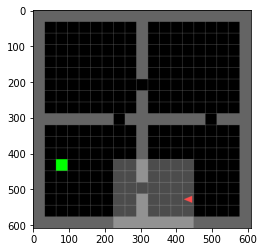

2

In [350]:
env = make_env()
env.seed(10)
obs = env.reset()
env.step(0)
render_state(env)
env.unwrapped.agent_dir

# env.unwrapped.agent_dir
# 0: right
# 1: down
# 2: left
# 3: up

In [6]:
obs = preprocess_obs(reset_env(env))
obs = obs_to_tensor(obs, DEVICE)

options = [ACNetwork(env.action_space.n).to(DEVICE)]
ac_net = ACNetwork(env.action_space.n, options).to(DEVICE)

print(ac_net(obs))
print(ac_net.sample_action(torch.cat([obs] * 10, dim=0)))
print(ac_net.sample_action(obs))

(tensor([[0., 0., 0., 0., 0., 0., 0., 0.]], device='cuda:0',
       grad_fn=<AddmmBackward>), tensor([[0.0155]], device='cuda:0', grad_fn=<AddmmBackward>))
tensor([3, 6, 3, 6, 5, 5, 4, 4, 4, 6], device='cuda:0')
tensor([6], device='cuda:0')


In [7]:
obs = preprocess_obs(reset_env(env))
obs = obs_to_tensor(obs, DEVICE)

eigen_function = EigenFunction().to(DEVICE)

print(obs.shape)
print(eigen_function(obs).shape)

torch.Size([1, 3, 19, 19])
torch.Size([1, 1])


In [8]:
def explore(actor, replay_buffer, n_steps=1000, steps_per_episode=100, env_seed=None):
    step = 0
    obs = preprocess_obs(reset_env(env, seed=env_seed))
    episode_step = 0
    while step < n_steps:
        act = actor.sample_action(obs_to_tensor(obs)).item()
        next_obs, reward, done, _ = env.step(act)
        next_obs = preprocess_obs(next_obs)
        replay_buffer.add_step((obs, act, reward, next_obs, done))

        if done or episode_step >= steps_per_episode:
            obs = preprocess_obs(reset_env(env, seed=env_seed))
            episode_step = 0
        else:
            obs = next_obs
            episode_step += 1
            
        step += 1

In [261]:
agent_indicator = np.array([10, 0, 1], dtype=np.uint8)
empty_indicator = np.array([1, 0, 0], dtype=np.uint8)

def learn_eigenvector(replay_buffer, batch_size=32, n_batches=100, lagrange_mult=1):
    eigen_function = EigenFunction().to(DEVICE)
    eigen_optimizer = optim.Adam(eigen_function.parameters(), lr=1e-3)

    losses = []
    for _ in range(n_batches):
        ### Loss Part 1 ###

        # Sample state transitions from history
        obs, _, _, next_obs, _ = replay_buffer.sample(batch_size)

        # Calculate values of eigenvector in samples states
        eigen_features = eigen_function(obs)
        next_eigen_features = eigen_function(next_obs)

        distance_losses = torch.square(eigen_features - next_eigen_features)

        
        ### Loss Part 2 ###

        # Sample state transitions from history
        obs, _, _, _, _ = replay_buffer.sample(batch_size)
        _, _, _, next_obs, _ = replay_buffer.sample(batch_size)

        # Calculate values of eigenvector in samples states
        eigen_features = eigen_function(obs)
        next_eigen_features = eigen_function(next_obs)

        repulsion_losses = \
            (torch.square(eigen_features) - 1) * \
            (torch.square(next_eigen_features) - 1) + \
            torch.square(eigen_features) * \
            torch.square(next_eigen_features)

        total_losses = 0.5 * distance_losses + lagrange_mult * repulsion_losses
        loss = torch.mean(total_losses)
        losses.append(loss.item())

        eigen_optimizer.zero_grad()
        loss.backward()
        eigen_optimizer.step()

    return eigen_function, losses

# Function that gets cutoff for a state being in the terminal set
# And it also returns a function for normalizing the eigenvector values
def get_ev_stats(eigen_function, replay_buffer, cutoff_percentile=0.1):
    obs, _, _, _, _ = replay_buffer.sample(len(replay_buffer.data))
    eigen_features = eigen_function(obs).detach().cpu().numpy()
    term_cutoff = np.percentile(eigen_features, 100 * cutoff_percentile)
    ef_min = eigen_features.min()
    ef_max = eigen_features.max()
    normalizer = lambda ef: (ef - ef_min) / (ef_max - ef_min)
    return term_cutoff, normalizer

def is_terminal(obs, eigen_function, term_cutoff):
    return eigen_function(obs).item() < term_cutoff

def render_eigenvector(eigen_function, env, env_seed, cutoff_value=None):
    ev_map = np.zeros((19, 19), dtype=np.float32)
    obs = reset_env(env, env_seed)
    agent_pos = env.unwrapped.agent_pos
    obs[agent_pos[0], agent_pos[1]] = empty_indicator
    for i in range(19):
        for j in range(19):
            if (obs[i, j] == empty_indicator).all():
                obs[i, j] = agent_indicator
                tensor_obs = obs_to_tensor(preprocess_obs(obs), DEVICE)
                ev_map[i, j] = eigen_function(tensor_obs).item()
                if cutoff_value is not None:
                    if ev_map[i, j] < cutoff_value:
                        ev_map[i, j] = 1
                    else:
                        ev_map[i, j] = 0.5
                obs[i, j] = empty_indicator
    ev_map = ev_map.T

    if cutoff_value is not None:
        plt.imshow(ev_map)
        return ev_map

    # Normalize the non-zero values of ev_map for plotting
    non_zero_indices = np.nonzero(ev_map)
    non_zero_indices = np.stack(non_zero_indices)
    non_zero_elements = ev_map[non_zero_indices[0], non_zero_indices[1]]
    min_val = non_zero_elements.min()
    max_val = non_zero_elements.max()
    ev_norm = np.zeros_like(ev_map)
    ev_norm[non_zero_indices[0], non_zero_indices[1]] = \
        (non_zero_elements - min_val) / (max_val - min_val)

    # Flip the map if necessary to make the more explored states lighter colored
    if ev_norm[agent_pos[0], agent_pos[1]] < 0.5:
        ev_norm[non_zero_indices[0], non_zero_indices[1]] = \
            1 - ev_norm[non_zero_indices[0], non_zero_indices[1]]

    plt.imshow(ev_norm)
    return ev_map
    
def render_agent_path(path, env, env_seed):
    ev_map = np.zeros((19, 19, 3), dtype=np.float32)
    obs = reset_env(env, env_seed)
    agent_pos = env.unwrapped.agent_pos
    print(agent_pos)
    obs[agent_pos[0], agent_pos[1]] = empty_indicator
    for i in range(19):
        for j in range(19):
            if (obs[i, j] == empty_indicator).all():
                ev_map[i, j] = 1

    for i in range(len(path)):
        color_val = 1 - (i/len(path))
        ev_map[path[i][0], path[i][1]] = [1, color_val, color_val]

    ev_map = ev_map.transpose(1, 0, 2)

    plt.imshow(ev_map)
    return ev_map

# Function that gets the reward for an option given a transition
def ev_reward_hook(eigen_function, ev_term_cutoff, ev_normalizer,
                   obs, act, reward, next_obs, done):
    both_obs = np.stack([obs, next_obs], axis=0)
    tensor_obs = obs_to_tensor(both_obs, DEVICE)
    eigen_features = eigen_function(tensor_obs)

    # Calculate the reward and if it has hit a terminal state
    efs_norm = ev_normalizer(eigen_features)
    reward = 1e3 * (eigen_features[0] - eigen_features[1]).item() # 10 * (efs_norm[0] - efs_norm[1]).item()
    if eigen_features[1].item() < ev_term_cutoff:
        done = True

    return obs, act, reward, next_obs, done

In [293]:
# Setup constants and objects
explore_steps = 20000
explore_steps_per_episode = 200
env_seed = 0

ev_batch_size = 32
ev_batches = 50
ev_term_percentile = 0.1
lagrange_mult = 1

option_train_steps = 10000
max_steps = 200

replay_buffer = ExperienceReplay(capacity=100000)

In [294]:
# Start loop

# Explore and gather samples
replay_buffer.clear()
exploration_policy = ACNetwork(env.action_space.n).to(DEVICE)
explore(exploration_policy, replay_buffer, explore_steps, env_seed)

# Learn the eigenvector
eigen_function, losses = learn_eigenvector(replay_buffer,
    ev_batch_size, ev_batches, lagrange_mult)
# Get the cutoff for the terminal set
ev_term_cutoff, ev_normalizer = get_ev_stats(eigen_function, replay_buffer, ev_term_percentile)    

<ipython-input-4-95dbd8d46284>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.asarray(self.data)[indices]


In [295]:
# Learn the eigenvector
eigen_function, losses = learn_eigenvector(replay_buffer,
    ev_batch_size, ev_batches, lagrange_mult)
# Get the cutoff for the terminal set
ev_term_cutoff, ev_normalizer = get_ev_stats(eigen_function, replay_buffer, ev_term_percentile)    

<ipython-input-4-95dbd8d46284>:17: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  samples = np.asarray(self.data)[indices]


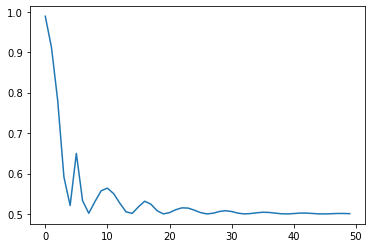

In [296]:
plt.plot(losses)

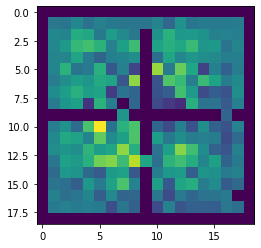

In [314]:
ev_map = render_eigenvector(eigen_function, env, env_seed)

In [315]:
agent_indicator = np.array([10, 0, 1])

0


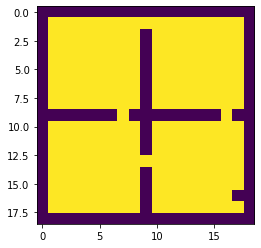

In [305]:
print(sum(((ev_map < ev_term_cutoff) & (ev_map > 0)).reshape(-1)))
terminal_map = render_eigenvector(eigen_function, env, env_seed, ev_term_cutoff)

In [280]:
# Wrapper for the environment to learn an option 
class OptionEnvWrapper(gym.Wrapper):
    def __init__(self, env, eigen_function, ev_term_cutoff):
        super().__init__(env)
        self.eigen_function = eigen_function
        self.ev_term_cutoff = ev_term_cutoff
        self.last_obs = None

        self.observation_space = gym.spaces.Box(
            low=0, high=1, shape=(3, 19, 19), dtype=np.uint8)
    
    def reset(self, **kwargs):
        env.seed(env_seed)
        obs = self.env.reset(**kwargs)
        obs = preprocess_obs(obs)
        self.last_obs = obs.copy()
        return obs

    def step(self, action):
        obs, reward, done, info = self.env.step(action)
        obs = preprocess_obs(obs)

        both_obs = np.stack([self.last_obs, obs], axis=0)
        tensor_obs = obs_to_tensor(both_obs, DEVICE)
        eigen_features = self.eigen_function(tensor_obs)

        reward = 1e3 * (eigen_features[0] - eigen_features[1]).item() # 10 * (efs_norm[0] - efs_norm[1]).item()
        if eigen_features[1].item() < self.ev_term_cutoff:
            done = True

        self.last_obs = obs.copy()

        return obs, reward, done, info

In [281]:
option_env = OptionEnvWrapper(env, eigen_function, ev_term_cutoff)

In [282]:
from stable_baselines3 import DQN, PPO
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor

In [283]:
class CustomCNN(BaseFeaturesExtractor):
    """
    :param observation_space: (gym.Space)
    :param features_dim: (int) Number of features extracted.
        This corresponds to the number of unit for the last layer.
    """

    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super(CustomCNN, self).__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with torch.no_grad():
            n_flatten = self.cnn(
                torch.as_tensor(observation_space.sample()[None]).float()
            ).shape[1]

        self.linear = nn.Sequential(
            nn.Linear(n_flatten, 2*features_dim),
            nn.ReLU(),
            nn.Linear(2*features_dim, features_dim),
            nn.ReLU())

    def forward(self, observations: torch.Tensor) -> torch.Tensor:
        return self.linear(self.cnn(observations))

policy_kwargs = dict(
    features_extractor_class=CustomCNN,
    features_extractor_kwargs=dict(features_dim=128),
)

In [284]:
# model = DQN("MlpPolicy", option_env, policy_kwargs=policy_kwargs, verbose=1, exploration_fraction=0.4)
model = PPO("MlpPolicy", option_env, policy_kwargs=policy_kwargs, verbose=1)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


In [285]:
model.learn(20000, log_interval=1);

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 29.4     |
|    ep_rew_mean     | 0.477    |
| time/              |          |
|    fps             | 286      |
|    iterations      | 1        |
|    time_elapsed    | 7        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 20.3         |
|    ep_rew_mean          | 0.539        |
| time/                   |              |
|    fps                  | 224          |
|    iterations           | 2            |
|    time_elapsed         | 18           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0069954162 |
|    clip_fraction        | 0.0569       |
|    clip_range           | 0.2          |
|    entropy_loss         | -1.94        |
|    explained_variance   | 0.0438       |
|    learning_r

In [193]:
model.predict(option_env.reset())

(5, None)

In [286]:
step = 0
obs = reset_env(option_env, seed=env_seed)
agent_path = [option_env.unwrapped.agent_pos]
while step < 1000:
    act_output = model.predict(obs)
    # print(act_output)
    act = act_output[0]

    next_obs, reward, done, _ = option_env.step(act)
    # print(reward)
    obs = next_obs
    agent_path.append(option_env.unwrapped.agent_pos)

    if done:
        break
        obs = reset_env(option_env, seed=env_seed)
        
    step += 1
print(step)

1


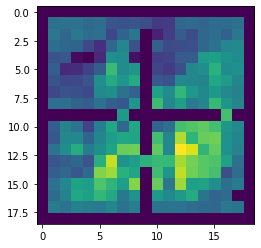

In [287]:
ev_map = render_eigenvector(eigen_function, env, env_seed)

[12  6]


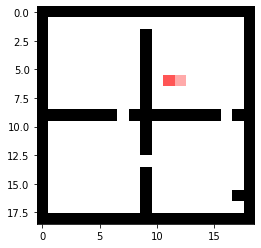

In [288]:
agent_path_map = render_agent_path(agent_path, env, env_seed)

In [18]:
# Edit here if we want options calling options
new_option = ACNetwork(env.action_space.n).to(DEVICE)
ppo_trainer = PPOTrainer(new_option)
rewards = train_with_ppo(
    new_option,
    ppo_trainer,
    option_env,
    max_steps,
    n_steps = option_train_steps,
    print_freq = 8)

Episode 8 | Step 493 | Avg Reward 0.8801445364952087
Episode 16 | Step 1026 | Avg Reward 0.20726025104522705
Episode 24 | Step 1537 | Avg Reward 0.01753866672515869
Episode 32 | Step 2147 | Avg Reward -0.0963360071182251
Episode 40 | Step 2765 | Avg Reward -1.2878626585006714
Episode 48 | Step 3380 | Avg Reward -0.8303448557853699
Episode 56 | Step 4089 | Avg Reward 0.4142746329307556
Episode 64 | Step 4320 | Avg Reward 0.20933151245117188
Episode 72 | Step 4936 | Avg Reward -0.10181963443756104
Episode 80 | Step 5475 | Avg Reward 0.2924501895904541
Episode 88 | Step 6085 | Avg Reward -0.3515854477882385
Episode 96 | Step 6695 | Avg Reward -0.31275302171707153
Episode 104 | Step 7107 | Avg Reward -0.38676708936691284
Episode 112 | Step 7816 | Avg Reward 0.0
Episode 120 | Step 8525 | Avg Reward 0.0
Episode 128 | Step 9333 | Avg Reward 0.0


KeyboardInterrupt: 

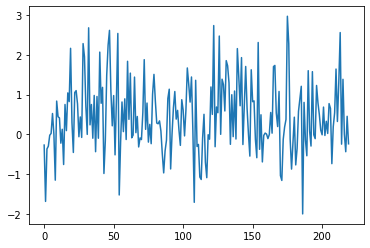

In [ ]:
plt.plot(rewards)

In [145]:
### Testing a gready approach with look-ahead ###

step = 0
obs = reset_env(option_env, seed=env_seed)
agent_path = [option_env.unwrapped.agent_pos]
while step < 20:
    max_reward = float('-inf')
    best_act = None
    pacts = []
    for act in range(7):
        cenv = copy.deepcopy(option_env)
        reward = cenv.step(act)[1]
        pacts.append(reward)
        if reward > max_reward:
            max_reward = reward
            best_act = act
    print(pacts, best_act)

    next_obs, reward, done, _ = option_env.step(best_act)
    print(reward)
    replay_buffer.add_step((obs, act, reward, next_obs, done))
    obs = next_obs
    agent_path.append(option_env.unwrapped.agent_pos)

    if done:
        obs = reset_env(option_env, seed=env_seed)
        
    step += 1

[0.07146596908569336, -0.09196996688842773, -0.4419088363647461, 0.0, 0.0, 0.0, 0.0] 0
0.07146596908569336
[0.05435943603515625, -0.07146596908569336, 0.052869319915771484, 0.0, 0.0, 0.0, 0.0] 0
0.05435943603515625
[-0.21779537200927734, -0.05435943603515625, 0.4951357841491699, 0.0, 0.0, 0.0, 0.0] 2
0.4951357841491699
[0.003039836883544922, 0.005066394805908203, -0.19317865371704102, 0.0, 0.0, 0.0, 0.0] 1
0.005066394805908203
[-0.005066394805908203, 0.00095367431640625, -0.308990478515625, 0.0, 0.0, 0.0, 0.0] 1
0.00095367431640625
[-0.00095367431640625, -0.0029802322387695312, -0.626981258392334, 0.0, 0.0, 0.0, 0.0] 3
0.0
[-0.00095367431640625, -0.0029802322387695312, -0.626981258392334, 0.0, 0.0, 0.0, 0.0] 3
0.0
[-0.00095367431640625, -0.0029802322387695312, -0.626981258392334, 0.0, 0.0, 0.0, 0.0] 3
0.0
[-0.00095367431640625, -0.0029802322387695312, -0.626981258392334, 0.0, 0.0, 0.0, 0.0] 3
0.0
[-0.00095367431640625, -0.0029802322387695312, -0.626981258392334, 0.0, 0.0, 0.0, 0.0] 3
0